# ising dynamics in dimension two

of course, following: http://bit-player.org/2021/three-months-in-monte-carlo

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import ipywidgets as widgets

initialize lattice

In [ ]:
def initialize_lattice(N):
    """Initialize the lattice with random spins."""
    lattice = np.random.choice([-1, 1], size=(N, N))
    return lattice

Metropolis and Glauber dynamics both rely on two main components: a visitation sequence and an acceptance function.

For now, we focus on the acceptance function.

The acceptance function takes in a spin $s_v$ on the lattice, associated to some vertex $v \in V$.

1. Calculate $\Delta E$, the change in energy that would result from flipping selected spin $s$. To determine this value, we need to examine $s$ itself and its four nearest neighbors.

2. Based on $\Delta E$ and the temperature $T$, calculate the probability $p$ of flipping spin $s$.

3. Generate a random number $r$ in the interval $[0,1)$. If $r < p$, flip the selected spin; otherwise leave it as is.

Part 2 of the acceptance rule calls for a mathematical function that maps values of $\Delta E$ and $T$ to a probability $p$.

This function should:
1. assign a higher probability to spin flips that reduce the system's energy, and
2. the system preference for negative $\Delta E$ should grow sharper as $T$ gets lower

The Glauber acceptance function is:

$$
p =
\frac{e^{-\Delta E /T}}
{1 + e^{-\Delta E /T}}
$$

Note that these are [Fermi-Dirac statistics](https://en.wikipedia.org/wiki/Fermi%E2%80%93Dirac_statistics).

In [11]:
def glauber_acceptance(delta_E, T):
    """Glauber acceptance function."""
    return np.exp(-delta_E / T) / (1 + np.exp(-delta_E / T))

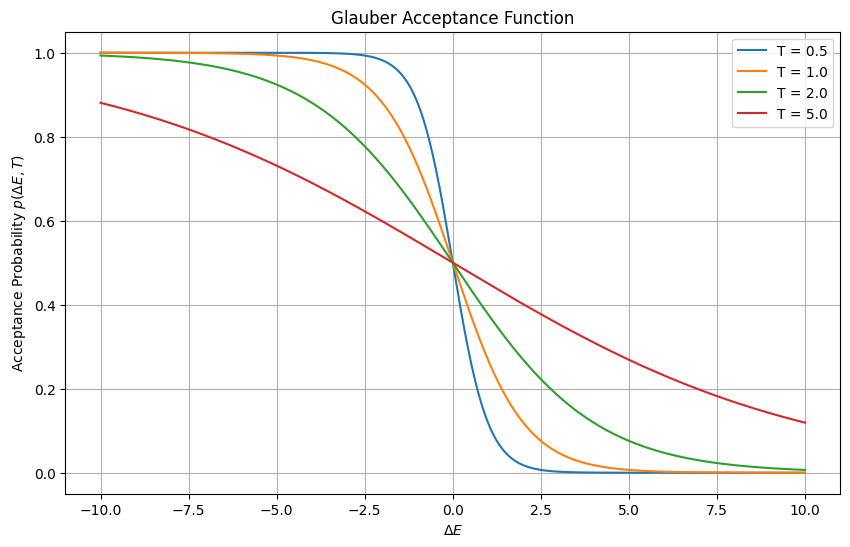

In [12]:
# Generate a range of Delta E values
delta_E_values = np.linspace(-10, 10, 400)

# Temperatures to plot
temperatures = [0.5, 1.0, 2.0, 5.0]
plt.figure(figsize=(10, 6))

for T in temperatures:
    p_values = glauber_acceptance(delta_E_values, T)
    plt.plot(delta_E_values, p_values, label=f'T = {T}')

plt.xlabel(r'$\Delta E$')
plt.ylabel('Acceptance Probability $p(\Delta E, T)$')
plt.title('Glauber Acceptance Function')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def metropolis_step(lattice, beta):
    """Perform one step of the Metropolis algorithm."""
    N = lattice.shape[0]
    i, j = np.random.randint(0, N, size=2)
    spin = lattice[i, j]
    neighbors = lattice[(i+1)%N, j] + lattice[(i-1)%N, j] + lattice[i, (j+1)%N] + lattice[i, (j-1)%N]
    delta_E = 2 * spin * neighbors

    if delta_E < 0 or np.random.rand() < np.exp(-beta * delta_E):
        lattice[i, j] *= -1

In [7]:




def simulate_glauber_interactive(lattice, beta, steps):
    """Simulate the Glauber dynamics and store snapshots."""
    snapshots = [lattice.copy()]
    for _ in range(steps):
        metropolis_step(lattice, beta)
        if _ % 1 == 0:  # Take a snapshot every 10 steps
            snapshots.append(lattice.copy())
    return snapshots

def plot_lattice(lattice, step):
    """Plot the lattice for a given step."""
    plt.imshow(lattice[step], cmap='gray')
    plt.title(f"Step {step}")
    plt.show()

In [8]:
# Parameters
N = 50          # Lattice size
beta = 0.4      # Inverse temperature
steps = 10000   # Number of steps

In [9]:
# Initialize and simulate
lattice = initialize_lattice(N)
snapshots = simulate_glauber_interactive(lattice, beta, steps)

In [10]:
# Create interactive plot
interact(plot_lattice, lattice=widgets.fixed(snapshots), step=IntSlider(min=0, max=len(snapshots)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='step', max=10000), Output()), _dom_classes=('widget-inte…

<function __main__.plot_lattice(lattice, step)>